# Notebook for calculating the resultant lenght or MRL of beacon 

1. import functions
2. Create combined 3D vector (XYZ, #beacons, time-secodns before beacon) 
3. Create and plot resultant lenght 
4. Combine resultant lenghts into one array for division (short,long)
5. Plot ratios as a histogram 
6. Combine into a function 
7. Calculate histogram over sessions
8. Make into function 
9. Compute Sham ( bootstrap like) comparison 
10. Plot histograms with sham medians on top of original data 
11. Compute sliding median and mean window - over time - plot differences with sham 
12. Bar plot 

In [1]:
import math
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from numpy import median
from scipy.stats import ranksums

root = 'C:/Users/Fabian/Desktop/Analysis/Multiple_trial_analysis/Data/Raw/'
figures = 'C:/Users/Fabian/Desktop/Analysis/Multiple_trial_analysis/Figures/'


## 1. Import functions from previous notebooks - 
Giving trajectories before beacon can be improved to have the whole trajectory before beacon to the time when another beacon is reached - which will result in uneven lenghts and can make that as list of arrays, but numpy is not made for that. 

In [2]:
from Data_analysis import *

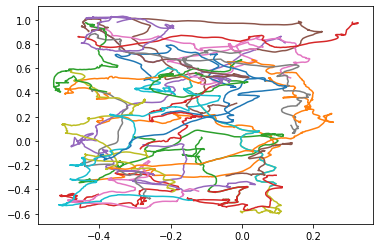

In [3]:
Day86_fs2 = pd.read_csv(root+'position 20200128-160013.txt',sep=" ", header=None)
Day86_fs1 = pd.read_csv(root+'position 20200128-151826.txt',sep=" ", header=None)

beacon_Day86_fs2 = pd.read_csv(root+'beacons 20200128-160013.txt',sep=" ", header=None)
beacon_Day86_fs1 = pd.read_csv(root+'beacons 20200128-151826.txt',sep=" ", header=None)

beacon_data = beacon_Day86_fs1
position_data = Day86_fs1

dist=[]
norm_x,norm_y,norm_time = position_before_beacon_trigger_beacon(5,beacon_data,position_data)
for i in np.arange(len(norm_x)):
    plt.plot(norm_x[i],norm_y[i])
    #dist.append(calculate_Distance(norm_x[i],norm_y[i])) - cannot be indexed into ... 
    


## 2. create combined vector lenght from trajectory,  can make it normalized if needed. 


#### A. Convert everything to Numpy - previously as a padnas dataframe - no need untill dedling with non-numbers 

In [4]:
beacon_d = beacon_data.to_numpy()
pos_data = position_data.to_numpy()
beacon_d[:, 0] -= pos_data[0][0]
pos_data[:, 0] -= pos_data[0][0]

#### B. Get index where beacon was reached. 

In [5]:
def get_index_at_pos(beacon_data, position_data):
    indexes = []
    for beacon_t in beacon_data[:, 0]:
        indexes.append( np.abs(beacon_t - position_data[:, 0]).argmin() )
        
    return indexes

#### C. Seperate function to create arrays of positions before beacon reached. 

In [6]:
def get_positions_before(seconds_back, idxs, position_data):
    """create arrays of positions before beacon reached"""
    beacon_periods = []
    for beacon_idx in idxs:
        beacon_t = position_data[beacon_idx][0]
        beacon_t_before = beacon_t - seconds_back
        before_idx = np.abs(beacon_t_before - position_data[:, 0]).argmin()
        beacon_periods.append(position_data[before_idx:beacon_idx])
        
    return beacon_periods

In [7]:
idxs = get_index_at_pos(beacon_d, pos_data)
periods = get_positions_before(3.5, idxs, pos_data)
np.asarray(periods).shape

(35,)

In [63]:
def position_before_beacon_trigger_beacon_array(seconds_back, beacon_data, position_data):
    """Take beacon data and returns XY and Time array defined in seconds before beacon """
    x_list=[]
    y_list=[]
    time_list=[] 
    num=0
    beacon_travel2=[]
    index, enum  = get_index(beacon_data, position_data)
    for i in index:
        print(i)
        if i <= seconds_back*100:
            i = seconds_back*100+1
            print('small')
            print(i)
        x_list.append(position_data[1][int(i-(seconds_back*100)):int(i)])
        y_list.append(position_data[3][int(i-(seconds_back*100)):int(i)])
        time_list.append((position_data[0][int(i-(seconds_back*100)):int(i)]- position_data[0][0]))
        k= np.asarray((time_list[0],x_list[0],y_list[0],))
        beacon_travel2.append(k)
        #print(time_list[0])
        x_list=[]
        y_list=[]
        time_list=[]
    return np.asarray(beacon_travel2)
beacon_travel= position_before_beacon_trigger_beacon_array(3.0, beacon_data, position_data)

418
5267
5871
7564
8020
12141
12587
19047
23102
23321
34878
36731
37660
37940
39351
51921
52561
53878
60705
61939
64016
64546
65104
73768
74188
74419
76498
79101
80279
93151
94459
99261
102101
104462
105025


### Looking at time if it is the correct array... - seems off beacause it is 3.3 seconds, instead of 3 seconds - more close to the 35 beacons - goign across a wrong axis? 

In [66]:
diff=[]
for i in range (299):
    diff.append(beacon_travel[1,0,i]-beacon_travel[1,0,i+1])
    
(sum(diff)) # so it is giving 5 seconds worth of trajectory? 

-4.980000019073486

In [11]:
len(beacon_travel[1,1,:])

500

In [12]:
print(beacon_travel.shape)

(35, 3, 500)


### Sanity check - checkt trajectories and how they look in real - here they equal - Question remaing why are time differences off?

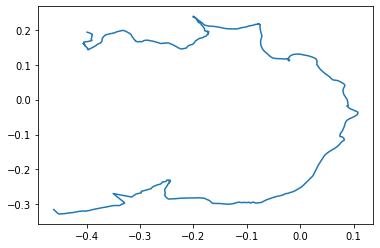

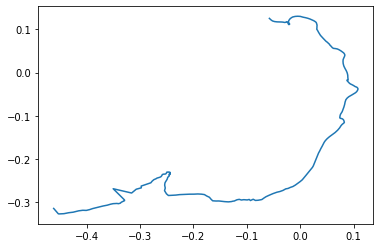

In [13]:
seconds_back = 3
index, enum  = get_index(beacon_data, position_data)
plt.plot(beacon_travel[1,1,:],beacon_travel[1,2,:]) # plotting trajectory of the second beacon...
plt.show()
plt.plot((position_data[1][index[1]-(seconds_back*100):index[1]]),(position_data[3][index[1]-(seconds_back*100):index[1]]))


## 3. create lenght of trajectory form start to end - i.e straight line 

In [14]:
straights=[]
longs=[]
for beacon in range(len(beacon_travel)):
    longs.append(calculate_Distance(beacon_travel[beacon,1,:],beacon_travel[beacon,2,:]))
    straights.append(math.sqrt((beacon_travel[beacon,1,0] - beacon_travel[beacon,1,-1]) ** 2 + (beacon_travel[beacon,2,0] - beacon_travel[beacon,2,-1]) ** 2))
print(longs)
print(straights)

[1.9856382655885827, 1.8871045468005532, 2.0658302686051297, 1.5784560369158125, 2.282854879643986, 2.3580290164914812, 1.2284628335770391, 0.5105120193989895, 1.875536225265254, 1.9944277195578721, 1.0023281297706437, 0.9548623650237349, 1.069703194200418, 1.3181101597270306, 1.1737013869788235, 0.726317192429774, 1.4954974597924033, 1.2609369198771476, 0.8592896953991532, 1.2500802760189555, 0.7716262660520107, 1.2185031437078853, 1.16533591661861, 1.257350232781638, 1.264893040401772, 1.264241284914833, 1.2806964556141915, 1.700004359253397, 1.4740505778813469, 1.184875247206975, 1.405886518803222, 1.4193489944179665, 1.29715585040386, 1.1855717983791059, 1.3677212506937146]
[0.6283691594972569, 0.5118111046696571, 0.3848985930962997, 0.22211726857049272, 1.1715485419846783, 0.4846096894225822, 0.027163830669926683, 0.1681223020929521, 1.2092286471697253, 0.8688846487533829, 0.24943983699600697, 0.2701247248023263, 0.5169924424527624, 0.23099253708069217, 0.44069186060104626, 0.3110

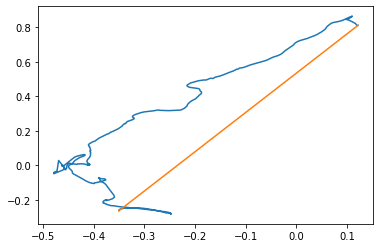

In [53]:
beacon = 4
plt.plot(beacon_travel[beacon,1,:],beacon_travel[beacon,2,:])
plt.plot([beacon_travel[beacon,1,0], beacon_travel[beacon,1,-1]] ,([beacon_travel[beacon,2,0],beacon_travel[beacon,2,-1]]))
    

In [57]:
def get_positions_before(seconds_back, idxs, position_data):
    """create arrays of positions before beacon reached"""
    beacon_periods = []
    for beacon_idx in idxs:
        beacon_t = position_data[beacon_idx][0]
        beacon_t_before = beacon_t - seconds_back
        before_idx = np.abs(beacon_t_before - position_data[:, 0]).argmin()
        beacon_periods.append(position_data[before_idx:beacon_idx])
        
    return beacon_periods
numpy_pos =get_positions_before(3.5, idxs, pos_data) 

### Sanity check: plotting the resultant lenght! - only first 16 in this case

0
vis
1
invis
2
vis
3
invis
4
vis
5
invis
6
vis
7
invis
8
vis
9
invis
10
vis
11
invis
12
vis
13
invis
14
vis
15
invis
1.6300000000000001
0.71


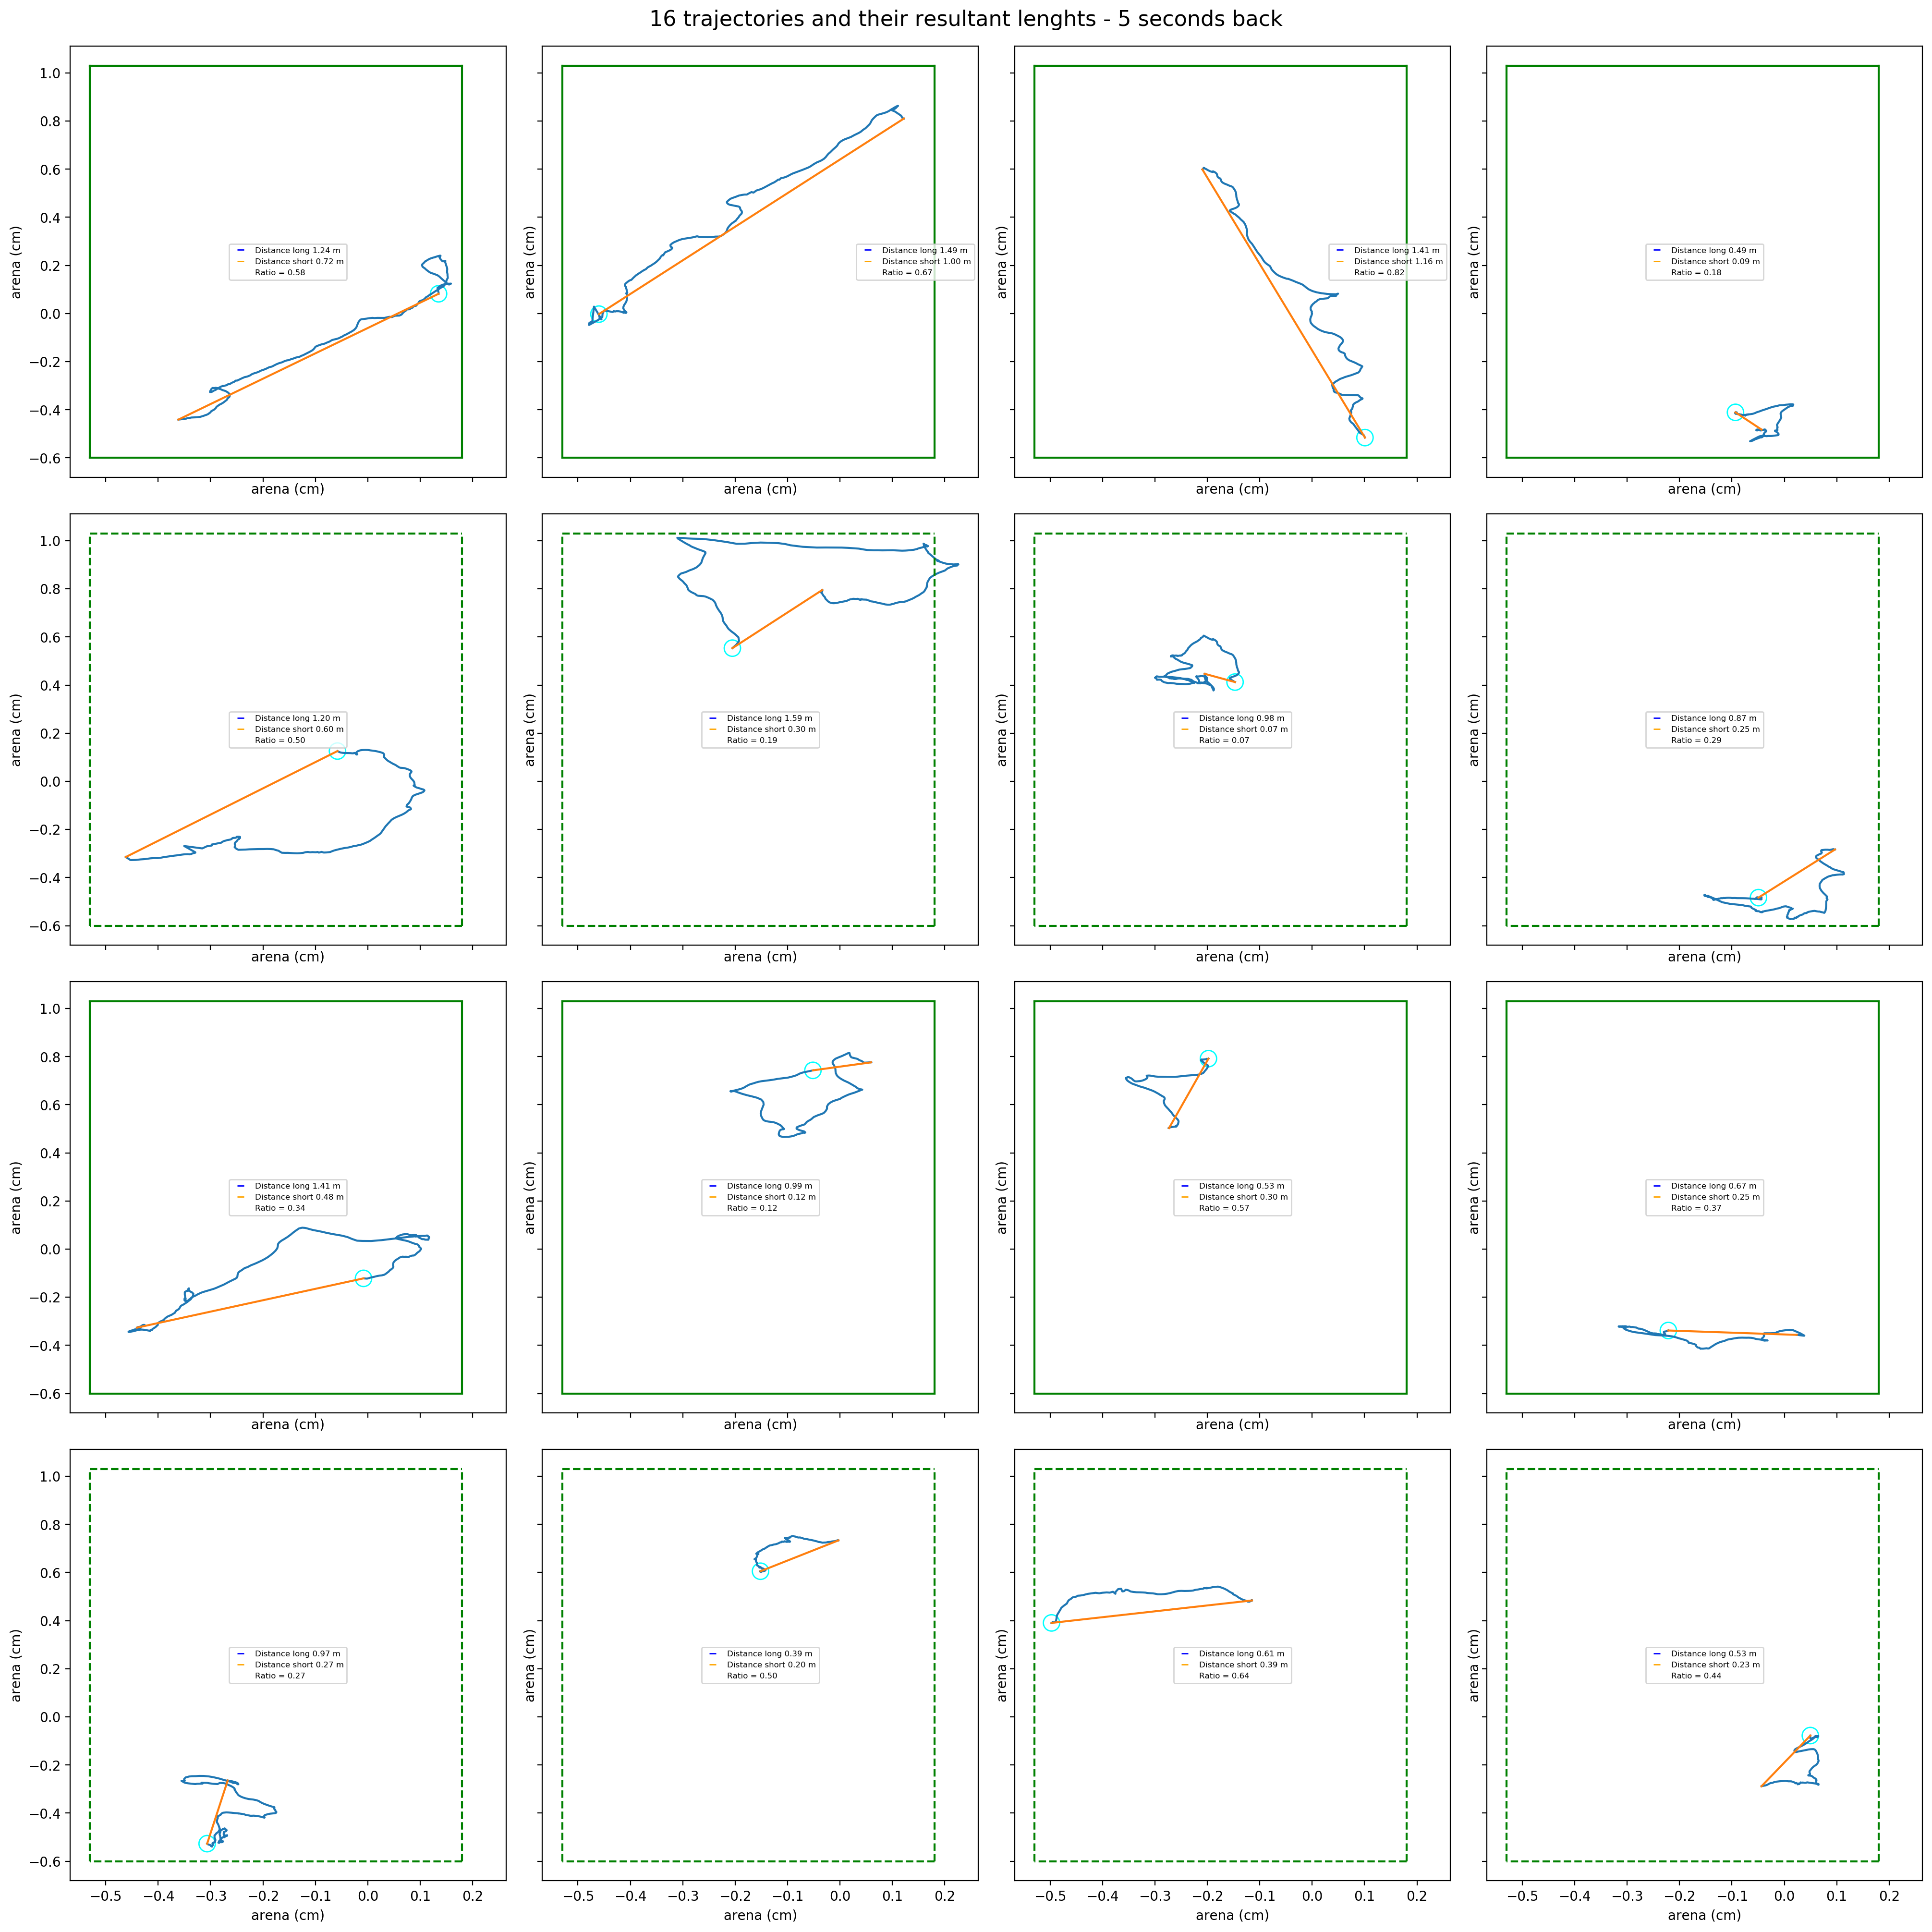

In [82]:
fig,ax = plt.subplots(4,4,figsize=(20,20),dpi=200,sharey=True,sharex=True,constrained_layout=True)
fig.suptitle('16 trajectories and their resultant lenghts - 5 seconds back',fontsize=16, )
#arena = 163 *71.5
X_cut_min = -.43
Y_cut_max = .93
X_cut_max = .08
Y_cut_min = -.50
cut=-.1
y_size = (Y_cut_max-Y_cut_min)-cut*2
x_size = (X_cut_max-X_cut_min)-cut*2

num=0
h=0
for beacon in range(16): 
    print(beacon)
    if beacon % 2 == 0:
        print('vis')
        border = "g-"
        circle= 'cyan'
    else:
        print('invis')
        border = 'g--'
        circle = 'cyan'
    s=(math.sqrt((beacon_travel[beacon,1,0] - beacon_travel[beacon,1,-1]) ** 2 + (beacon_travel[beacon,2,0] - beacon_travel[beacon,2,-1]) ** 2))
    
    l=calculate_Distance(beacon_travel[beacon,1,:],beacon_travel[beacon,2,:])
    
    ax[h][num].plot(beacon_travel[beacon,1,:],beacon_travel[beacon,2,:])
    ax[h][num].plot([beacon_travel[beacon,1,0], beacon_travel[beacon,1,-1]] ,([beacon_travel[beacon,2,0],beacon_travel[beacon,2,-1]]))
    
    
    distl = mlines.Line2D([], [], marker='_',markersize=5,markerfacecolor="blue",
                            markeredgecolor="blue",linewidth = 0, label='Distance long %.2f m' %l)
    dists = mlines.Line2D([], [], marker='_',markersize=5,markerfacecolor="orange",
                            markeredgecolor="orange",linewidth = 0, label='Distance short %.2f m' %s)
    diff = mlines.Line2D([], [], marker=" ",linewidth = 0, label='Ratio = %.2f ' %(s/l))
    
    ax[h][num].scatter(beacon_travel[beacon,1,0],beacon_travel[beacon,2,0] ,s=150, facecolors='none', edgecolors=circle)
    
    ax[h][num].plot([(X_cut_min+cut),(X_cut_max-cut)],[(Y_cut_max-cut),(Y_cut_max-cut)] ,border)
    ax[h][num].plot([(X_cut_min+cut),(X_cut_min+cut)],[(Y_cut_min+cut),(Y_cut_max-cut)] ,border)
    ax[h][num].plot([(X_cut_max-cut),(X_cut_max-cut)],[(Y_cut_min+cut),(Y_cut_max-cut)] ,border)
    ax[h][num].plot([(X_cut_max-cut),(X_cut_min+cut)],[(Y_cut_min+cut),(Y_cut_min+cut)] ,border)
    
        
    ax[h][num].legend(handles=[distl,dists,diff],loc='best',prop={'size': 6})
    ax[h][num].set_ylabel('arena (cm)')
    ax[h][num].set_xlabel('arena (cm)')
    
    l=0
    s=0
    h+=1
    if h % 4==0:
        num += 1
        h=0

print(y_size)        
print(x_size)     
plt.savefig('%s16_trajectories_5_sec._before_beacons_.png' %(figures), dpi = 300)    

#plt.tight_layout()
plt.show()


## 4. combine the two arrays into one - 0th column lenght of trajectory, 1st column lenght of straight line 

In [12]:
resultant= (np.asarray(longs),np.asarray(straights))
np.asarray(resultant).shape

(2, 35)

In [13]:
def ratios (list1,list2):
    resultant= (np.asarray(list1),np.asarray(list2))
    div = []
    for i in range(len(resultant[1])):
        div.append(resultant[1][i]/resultant[0][i])
    return np.asarray(div)
div = ratios(longs,straights)

## 5. Plot as a into a histogram,

0.4852900203770642
0.46488407982038094


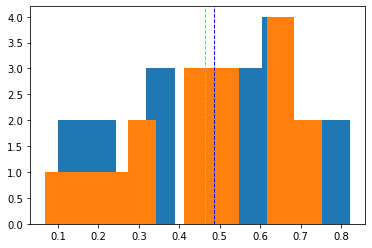

In [14]:
div=np.asarray(div)
plt.hist(div[::2])
plt.hist(div[1::2])
np.mean(div[::2])
plt.axvline(div[::2].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(div[1::2].mean(), color='orange', linestyle='dashed', linewidth=1)
print(div[0::2].mean())
print(div[1::2].mean())


## 6.Make a function out of it

#### This function takes beaconn and position and graphs the percentage of lenght of trajecotries for a visible and invisible beacon - FOR INDIVIDUAL SESSIONS



0.4852900203770642
0.46488407982038094


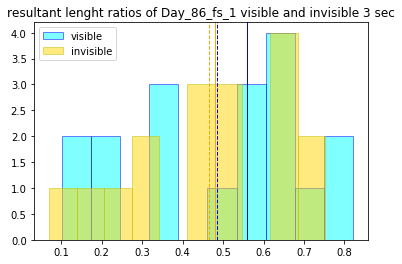

In [15]:
Day86_fs2 = pd.read_csv(root+'position 20200128-160013.txt',sep=" ", header=None)
Day86_fs1 = pd.read_csv(root+'position 20200128-151826.txt',sep=" ", header=None)

beacon_Day86_fs2 = pd.read_csv(root+'beacons 20200128-160013.txt',sep=" ", header=None)
beacon_Day86_fs1 = pd.read_csv(root+'beacons 20200128-151826.txt',sep=" ", header=None)

beacon_data = beacon_Day86_fs1
position_data = Day86_fs1

def resultant_lenght_vis_invis(position_data, beacon_data,seconds_back,name):
    """This function takes beaconn and position and graphs the percentage of lenght of trajecotries for a visible and invisible beacon - FOR INDIVIDUAL SESSIONS"""
    beacon_travel = position_before_beacon_trigger_beacon_array(seconds_back, beacon_data, position_data)
    straights=[]
    longs=[]
    for beacon in range(len(beacon_travel)):
        longs.append(calculate_Distance(beacon_travel[beacon,1,:],beacon_travel[beacon,2,:]))
        straights.append(math.sqrt((beacon_travel[beacon,1,0] - beacon_travel[beacon,1,-1]) ** 2 + (beacon_travel[beacon,2,0] - beacon_travel[beacon,2,-1]) ** 2))
    div = ratios(longs,straights)

    plt.hist(div[::2],alpha=.5,color='cyan', edgecolor='blue',label='visible')
    plt.hist(div[1::2],alpha=.5,color='gold', edgecolor='y', label='invisible')
    blue_line = mlines.Line2D([], [], color='blue', marker='_',
                          markersize=15, label='Blue stars')
    plt.legend()
    np.mean(div[::2])
    plt.axvline(div[::2].mean(), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(div[1::2].mean(), color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(div[::2]), color='blue', linestyle='solid', linewidth=1)
    plt.axvline(np.median(div[1::2]), color='orange', linestyle='solid', linewidth=1)
    #plt.axvline(np.std(div[::2]), color='blue', linestyle='dashdot', linewidth=1)
    #plt.axvline(np.std(div[1::2]), color='orange', linestyle='dashdot', linewidth=1)
    print(div[0::2].mean())
    print(div[1::2].mean())
    plt.title('resultant lenght ratios of %s visible and invisible %s sec'%(name,seconds_back))
    plt.savefig('%sresultant_lenght_ratios_%s_visible_invisible_%s.png' %(figures,seconds_back,name ), dpi = 100) 

    
resultant_lenght_vis_invis(position_data,beacon_data,3,'Day_86_fs_1')


0.49347385827093987
0.394206727884158


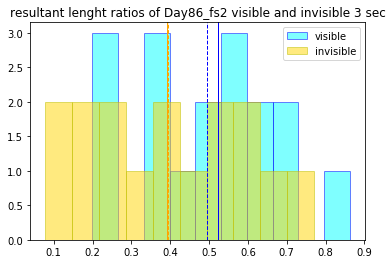

In [16]:
resultant_lenght_vis_invis(Day86_fs2 ,beacon_Day86_fs2,3,'Day86_fs2')

0.3918050483046605
0.44519153469238676


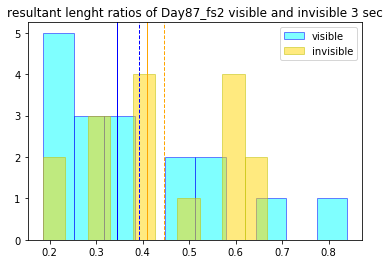

In [17]:
resultant_lenght_vis_invis(Day87_fs2 ,beacon_Day87_fs2,3,'Day87_fs2')

0.44254338305439506
0.45008032906447454


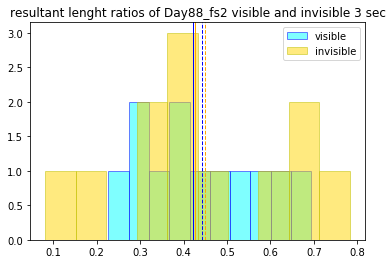

In [18]:
resultant_lenght_vis_invis(Day88_fs2 ,beacon_Day88_fs2,3,'Day88_fs2')

0.5123835304764198
0.42746515034854227


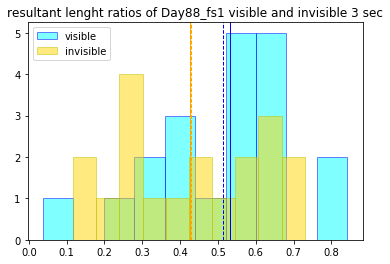

In [19]:
resultant_lenght_vis_invis(Day88_fs1 ,beacon_Day88_fs1,3,'Day88_fs1')

## 7. Calculate histogram over all sessions 

In [20]:
beacons = [beacon_Day86_fs1,beacon_Day87_fs1,beacon_Day88_fs1,beacon_Day89_fs1,beacon_Day90_fs1,beacon_Day91_fs1,beacon_Day92_fs1,beacon_Day93_fs1]
beacons2 = [beacon_Day86_fs2,beacon_Day87_fs2,beacon_Day88_fs2,beacon_Day89_fs2,beacon_Day90_fs2,beacon_Day91_fs2,beacon_Day92_fs2,beacon_Day93_fs2]
list_of_days = [Day86_fs1,Day87_fs1,Day88_fs1,Day89_fs1,Day90_fs1,Day91_fs1,Day92_fs1,Day93_fs1]
list_of_days2 = [Day86_fs2,Day87_fs2,Day88_fs2,Day89_fs2,Day90_fs2,Day91_fs2,Day92_fs2,Day93_fs2]
Day_list = list_of_days+list_of_days2
Beacon_list = beacons+beacons2
len(list_of_days)== len(beacons) 

True

In [21]:
def resultant_lenght_vis_invis_all (list_of_days,beacon,seconds_back):
    div = []
    for index,(position,beaconz) in enumerate(zip (Day_list,Beacon_list)):  
        beacon_travel = position_before_beacon_trigger_beacon_array(seconds_back, beaconz, position)
        straights=[]
        longs=[]   
        for beacon in range(len(beacon_travel)):
            longs.append(calculate_Distance(beacon_travel[beacon,1,:],beacon_travel[beacon,2,:]))
            straights.append(math.sqrt((beacon_travel[beacon,1,0] - beacon_travel[beacon,1,-1]) ** 2 + (beacon_travel[beacon,2,0] - beacon_travel[beacon,2,-1]) ** 2))
        div.append(np.asarray((ratios(longs,straights))))
    return(np.asarray(div))

large_div = resultant_lenght_vis_invis_all(Day_list, Beacon_list,4)

In [22]:
large_div[1]

array([0.50582865, 0.41351082, 0.33170349, 0.69514637, 0.31952011,
       0.5494717 , 0.07011552, 0.45244031, 0.44704285, 0.33721922,
       0.64386386, 0.31648341, 0.52266372, 0.64403071, 0.44630051,
       0.27159327, 0.63393354])

RanksumsResult(statistic=-0.27103010417681, pvalue=0.7863678787119113)
4


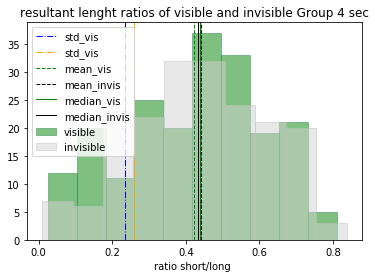

In [23]:
def histogram_ratio_all (list_of_days,beacon,seconds_back):

    large_div = resultant_lenght_vis_invis_all (list_of_days,beacon,seconds_back)


    large_mean_vis=[]
    large_median_vis=[]
    large_mean_invis=[]
    large_median_invis=[]

    for div in range(len(large_div)):

        #within group stats - not pooled 
        large_mean_vis.append(large_div[div][::2].mean())
        large_mean_invis.append(large_div[div][1::2].mean())
        large_median_vis.append(np.median(large_div[div][::2]))
        large_median_invis.append(np.median(large_div[div][1::2]))
    vis = [item for sublist in large_div for item in sublist[::2]]  #cool list feature - flatening lists
    invis = [item for sublist in large_div for item in sublist[1::2]]
    print(ranksums(vis, invis))
    plt.hist(vis,alpha=.5,color='g', edgecolor='seagreen',label='visible')
    plt.hist(invis,alpha=.5,color='lightgrey', edgecolor='silver',label='invisible')
    plt.axvline((np.mean(np.asarray(large_mean_vis))-np.std(vis)), color='blue', linestyle='dashdot', linewidth=1,label='std_vis')
    plt.axvline((np.mean(np.asarray(large_mean_invis))-np.std(invis)), color='orange', linestyle='dashdot', linewidth=1,label='std_vis')

    

    plt.axvline(np.mean(np.asarray(large_mean_vis)), color='g', linestyle='dashed', linewidth=1,label='mean_vis')
    plt.axvline(np.mean(np.asarray(large_mean_invis)), color='black', linestyle='dashed', linewidth=1,label='mean_invis')
    plt.axvline(np.median(np.asarray(large_median_vis)), color='g', linestyle='solid', linewidth=1,label='median_vis')
    plt.axvline(np.median(np.asarray(large_median_invis)), color='black', linestyle='solid', linewidth=1,label='median_invis')
    plt.xlabel("ratio short/long ")
    plt.legend()
    print (seconds_back)
    plt.title('resultant lenght ratios of visible and invisible Group %s sec'% seconds_back)
    plt.savefig('%sresultant_lenght_ratios_%s_visible_invisible_all.png' %(figures,seconds_back), dpi = 200) 
    plt.show()
histogram_ratio_all (Day_list, Beacon_list , 4 )

RanksumsResult(statistic=0.5038494067811518, pvalue=0.6143672055912077)
3


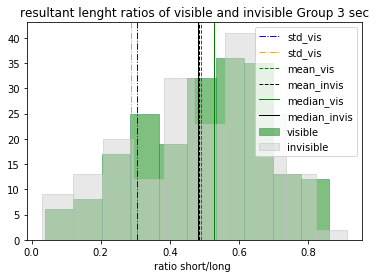

In [24]:
histogram_ratio_all (Day_list, Beacon_list,3)

RanksumsResult(statistic=-0.22126719980336293, pvalue=0.8248843877882177)
2


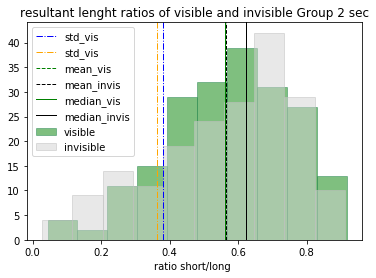

In [25]:
histogram_ratio_all (Day_list, Beacon_list,2)

RanksumsResult(statistic=-0.8681849566581751, pvalue=0.38529308819371855)
1


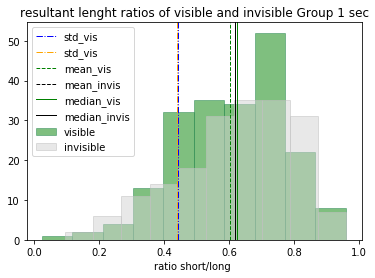

In [26]:
histogram_ratio_all (Day_list, Beacon_list,1)

small
small
small
RanksumsResult(statistic=-0.6913489214739613, pvalue=0.48934629502886473)
5


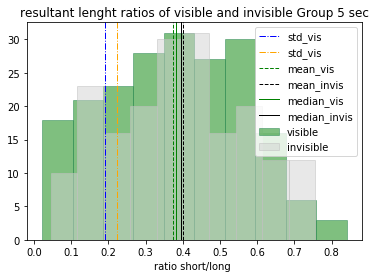

In [27]:
histogram_ratio_all (Day_list, Beacon_list,5)

small
small
small
small
small
RanksumsResult(statistic=-1.1827576021617512, pvalue=0.23690522805714087)
6


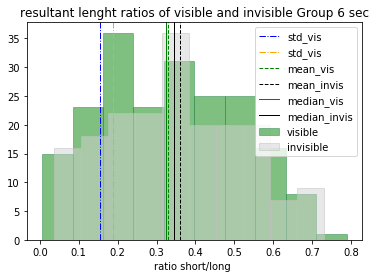

In [28]:
histogram_ratio_all (Day_list, Beacon_list,6)

RanksumsResult(statistic=-0.16528393238323497, pvalue=0.8687205049819975)
3.5


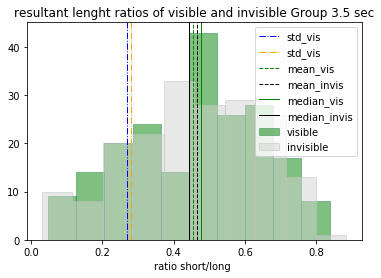

In [29]:
histogram_ratio_all (Day_list, Beacon_list,3.5)

203 190
RanksumsResult(statistic=-0.22126719980336293, pvalue=0.8248843877882177)
2


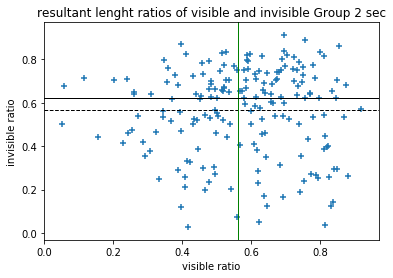

In [30]:
def scatter_ratio_all (list_of_days,beacon,seconds_back):

    large_div = resultant_lenght_vis_invis_all (list_of_days,beacon,seconds_back)


    large_mean_vis=[]
    large_median_vis=[]
    large_mean_invis=[]
    large_median_invis=[]

    for div in range(len(large_div)):

        #within group stats - not pooled 
        large_mean_vis.append(large_div[div][::2].mean())
        large_mean_invis.append(large_div[div][1::2].mean())
        large_median_vis.append(np.median(large_div[div][::2]))
        large_median_invis.append(np.median(large_div[div][1::2]))
    vis = [item for sublist in large_div for item in sublist[::2]]  #cool list feature - flatening lists
    invis = [item for sublist in large_div for item in sublist[1::2]]

    #plt.hist(vis,alpha=.5,color='g', edgecolor='seagreen',label='visible')
    #plt.hist(invis,alpha=.5,color='lightgrey', edgecolor='silver',label='invisible')

    print(len(vis),len(invis),)
    plt.scatter(vis[:189],invis[:189],marker="+")
    print(ranksums(vis, invis))

    plt.xlabel('visible ratio')
    plt.ylabel('invisible ratio')
    plt.axvline(np.mean(np.asarray(large_mean_vis)), color='g', linestyle='dashed', linewidth=1)
    plt.axhline(np.mean(np.asarray(large_mean_invis)), color='black', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(np.asarray(large_median_vis)), color='g', linestyle='solid', linewidth=1)
    plt.axhline(np.median(np.asarray(large_median_invis)), color='black', linestyle='solid', linewidth=1)
    print (seconds_back)
    plt.title('resultant lenght ratios of visible and invisible Group %s sec'% seconds_back)
    plt.savefig('%sresultant_lenght_ratios_scatter_%s_visible_invisible_all.png' %(figures,seconds_back), dpi = 200) 
    plt.show()
scatter_ratio_all (Day_list, Beacon_list , 2 )



## 8. Sham calculations 

1. Create random numbers based on the lenght of the recordign and the amount of beacons. 
2. Use the indexes to index into the data,  
3. Generate the histograms and resultant lenght for that data. 



In [31]:
import random as rn

In [32]:
Day86_fs2 = pd.read_csv(root+'position 20200128-160013.txt',sep=" ", header=None)
Day86_fs1 = pd.read_csv(root+'position 20200128-151826.txt',sep=" ", header=None)

beacon_Day86_fs2 = pd.read_csv(root+'beacons 20200128-160013.txt',sep=" ", header=None)
beacon_Day86_fs1 = pd.read_csv(root+'beacons 20200128-151826.txt',sep=" ", header=None)

beacon_data = beacon_Day86_fs1
position_data = Day86_fs1

print(len(beacon_data))
print(len(position_data))

rn.randrange(0, len(position_data),len(beacon_data))
my_randoms = rn.sample(range(1, len(position_data)), len(beacon_data))

print(len(my_randoms))
print(max(my_randoms))

35
107975
35
103349


In [184]:
def position_before_beacon_trigger_beacon_array_sham(seconds_back, beacon_data, position_data):
    """Take beacon data and returns XY and Time array defined in seconds before beacon """
    x_list=[]
    y_list=[]
    time_list=[] 
    beacon_travel2=[]
    randoms = rn.sample(range(1, len(position_data)), len(beacon_data))
    for i in randoms:
        if i <= seconds_back*100:
            i = int(seconds_back*100+1)
        x_list.append(position_data[1][int(i-(seconds_back*100)):int(i)])
        y_list.append(position_data[3][int(i-(seconds_back*100)):int(i)])
        time_list.append((position_data[0][int(i-(seconds_back*100)):int(i)]-position_data[0][0]))
        k= np.asarray((time_list[0],x_list[0],y_list[0],))
        beacon_travel2.append(k)
        x_list=[]
        y_list=[]
        time_list=[]
    return np.asarray(beacon_travel2)
beacon_travel= position_before_beacon_trigger_beacon_array_sham(2.2, beacon_data, position_data)

In [34]:
def resultant_lenght_vis_invis_all_sham (list_of_days,beacon,seconds_back):
    div = []
    for index,(position,beaconz) in enumerate(zip (Day_list,Beacon_list)):  
        beacon_travel = position_before_beacon_trigger_beacon_array_sham(seconds_back, beaconz, position)
        straights=[]
        longs=[]   
        for beacon in range(len(beacon_travel)):
            longs.append(calculate_Distance(beacon_travel[beacon,1,:],beacon_travel[beacon,2,:]))
            straights.append(math.sqrt((beacon_travel[beacon,1,0] - beacon_travel[beacon,1,-1]) ** 2 + (beacon_travel[beacon,2,0] - beacon_travel[beacon,2,-1]) ** 2))
        div.append(np.asarray((ratios(longs,straights))))
    return(np.asarray(div))

large_div_sham = resultant_lenght_vis_invis_all_sham(Day_list, Beacon_list,4)

3


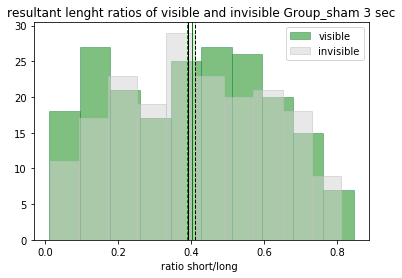

In [35]:
def histogram_ratio_all_sham  (list_of_days,beacon,seconds_back):

    large_div_sham = resultant_lenght_vis_invis_all_sham (list_of_days,beacon,seconds_back)


    large_mean_vis=[]
    large_median_vis=[]
    large_mean_invis=[]
    large_median_invis=[]

    for div in range(len(large_div)):

        #within group stats - not pooled 
        large_mean_vis.append(large_div_sham[div][::2].mean())
        large_mean_invis.append(large_div_sham[div][1::2].mean())
        large_median_vis.append(np.median(large_div_sham[div][::2]))
        large_median_invis.append(np.median(large_div_sham[div][1::2]))
    vis = [item for sublist in large_div_sham for item in sublist[::2]]  #cool list feature - flatening lists
    invis = [item for sublist in large_div_sham for item in sublist[1::2]]

    plt.hist(vis,alpha=.5,color='g', edgecolor='seagreen',label='visible')
    plt.hist(invis,alpha=.5,color='lightgrey', edgecolor='silver',label='invisible')

    plt.legend()

    plt.axvline(np.mean(np.asarray(large_mean_vis)), color='g', linestyle='dashed', linewidth=1)
    plt.axvline(np.mean(np.asarray(large_mean_invis)), color='black', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(np.asarray(large_median_vis)), color='g', linestyle='solid', linewidth=1)
    plt.axvline(np.median(np.asarray(large_median_invis)), color='black', linestyle='solid', linewidth=1)
    plt.xlabel("ratio short/long ")
    print (seconds_back)
    plt.title('resultant lenght ratios of visible and invisible Group_sham %s sec'% seconds_back)
    plt.savefig('%sresultant_lenght_ratios_%s_visible_invisible_all_sham.png' %(figures,seconds_back), dpi = 200) 
    plt.show()
histogram_ratio_all_sham (Day_list, Beacon_list , 3 )

### 9. Bootstrapping 

In [36]:
def histogram_ratio_all_boot  (list_of_days,beacon,seconds_back):

    large_div_sham = resultant_lenght_vis_invis_all_sham (list_of_days,beacon,seconds_back)


    large_mean_vis=[]
    large_median_vis=[]
    large_mean_invis=[]
    large_median_invis=[]

    for div in range(len(large_div)):

        #within group stats - not pooled 
        large_mean_vis.append(large_div_sham[div][::2].mean())
        large_mean_invis.append(large_div_sham[div][1::2].mean())
        large_median_vis.append(np.median(large_div_sham[div][::2]))
        large_median_invis.append(np.median(large_div_sham[div][1::2]))
    vis = [item for sublist in large_div_sham for item in sublist[::2]]  #cool list feature - flatening lists
    invis = [item for sublist in large_div_sham for item in sublist[1::2]]

    #plt.hist(vis,alpha=.5,color='g', edgecolor='seagreen',label='visible')
    #plt.hist(invis,alpha=.5,color='lightgrey', edgecolor='silver',label='invisible')

    #plt.legend()

    mean_vis= np.mean(np.asarray(large_mean_vis)), 
    mean_invis = np.mean(np.asarray(large_mean_invis)), 
    median_vis = np.median(np.asarray(large_median_vis)), 
    median_invis = np.median(np.asarray(large_median_invis)),
    #print (seconds_back)
    return [mean_vis,mean_invis, median_vis,median_invis]
    
histogram_ratio_all_boot (Day_list, Beacon_list , 3 )

[(0.40486135333184436,),
 (0.397725123975791,),
 (0.4050022215337265,),
 (0.40223530725784434,)]

## Bootstrap - calculate means and sampled data over X times also for whatever times 

In [37]:
ave=[]
for i in range (100):
    ave.append(histogram_ratio_all_boot (Day_list, Beacon_list , 2 ))
    

In [38]:
def strapped_means (ave):
    ave_all = []
    mean_vis_boot =[]
    mean_invis_boot=[]
    median_vis_boot=[]
    median_invis_boot=[] 
    bins=25
    for i in range(len(ave)):
        mean_vis_boot.append(ave[i][0])
        mean_invis_boot.append(ave[i][1])
        median_vis_boot.append(ave[i][2])
        median_invis_boot.append(ave[i][3])
        

    return [np.mean(mean_vis_boot), np.mean(mean_invis_boot), np.median(np.asarray(median_vis_boot)),np.median(median_invis_boot)]

In [39]:
ave_all_boot= strapped_means(ave)

In [40]:
ave_all_boot




[0.44175383440727595,
 0.43922878050309366,
 0.4430656734090616,
 0.4361936324150692]

## Function to generate stats for given seconds... 


In [41]:
def get_boot_data(seconds_back,boot_reps):
    histogram_ratio_all_boot (Day_list, Beacon_list , seconds_back )
    ave=[]
    for i in range (boot_reps):
        ave.append(histogram_ratio_all_boot (Day_list, Beacon_list , 2 ))
    ave_all_boot= strapped_means(ave)
    return ave_all_boot
    
get_boot_data(3,10)


[0.44610571403932464,
 0.4461194220599234,
 0.44684941584447313,
 0.45418049691768947]

### statistics on ratios of the original correctly samples data

In [42]:
def histogram_ratio_all_nums  (list_of_days,beacon,seconds_back):

    large_div = resultant_lenght_vis_invis_all (list_of_days,beacon,seconds_back)


    large_mean_vis=[]
    large_median_vis=[]
    large_mean_invis=[]
    large_median_invis=[]

    for div in range(len(large_div)):

        #within group stats - not pooled 
        large_mean_vis.append(large_div[div][::2].mean())
        large_mean_invis.append(large_div[div][1::2].mean())
        large_median_vis.append(np.median(large_div[div][::2]))
        large_median_invis.append(np.median(large_div[div][1::2]))
    vis = [item for sublist in large_div for item in sublist[::2]]  #cool list feature - flatening lists
    invis = [item for sublist in large_div for item in sublist[1::2]]

    #plt.hist(vis,alpha=.5,color='g', edgecolor='seagreen',label='visible')
    #plt.hist(invis,alpha=.5,color='lightgrey', edgecolor='silver',label='invisible')

    #plt.legend()

    mean_vis= np.mean(np.asarray(large_mean_vis)), 
    mean_invis = np.mean(np.asarray(large_mean_invis)), 
    median_vis = np.median(np.asarray(large_median_vis)), 
    median_invis = np.median(np.asarray(large_median_invis)),
    #print (seconds_back)
    return [mean_vis,mean_invis, median_vis,median_invis]
    
ave_all = histogram_ratio_all_nums (Day_list, Beacon_list , 3 )

In [43]:
ave_all

[(0.4905742781433466,),
 (0.48421427587924953,),
 (0.5274732335206233,),
 (0.4817772153014079,)]

## 10. Graph together with bootstrapped data: 

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
D:\Software\anaconda\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


RanksumsResult(statistic=0.5038494067811518, pvalue=0.6143672055912077)
3


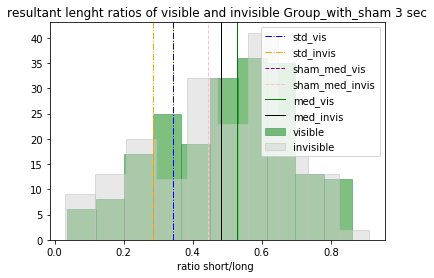

In [44]:
def histogram_ratio_with_sham (list_of_days,beacon,seconds_back,boot_reps):

    large_div = resultant_lenght_vis_invis_all (list_of_days,beacon,seconds_back)


    large_mean_vis=[]
    large_median_vis=[]
    large_mean_invis=[]
    large_median_invis=[]
    
    ave_all_boot = get_boot_data(seconds_back,boot_reps)
    
    for div in range(len(large_div)):

        #within group stats - not pooled 
        large_mean_vis.append(large_div[div][::2].mean())
        large_mean_invis.append(large_div[div][1::2].mean())
        large_median_vis.append(np.median(large_div[div][::2]))
        large_median_invis.append(np.median(large_div[div][1::2]))
    vis = [item for sublist in large_div for item in sublist[::2]]  #cool list feature - flatening lists
    invis = [item for sublist in large_div for item in sublist[1::2]]
    print(ranksums(vis, invis))
    plt.hist(vis,alpha=.5,color='g', edgecolor='seagreen',label='visible')
    plt.hist(invis,alpha=.5,color='lightgrey', edgecolor='silver',label='invisible')
    plt.axvline((np.median(np.asarray(large_median_vis))-np.std(vis)), color='blue', linestyle='dashdot', linewidth=1,label='std_vis')
    plt.axvline((np.median(np.asarray(large_median_invis))-np.std(invis)), color='orange', linestyle='dashdot', linewidth=1,label='std_invis')
    plt.axvline(ave_all_boot[2], color='purple', linestyle='dashed', linewidth=1,label='sham_med_vis')
    plt.axvline(ave_all_boot[3], color='pink', linestyle='dashed', linewidth=1,label='sham_med_invis')
    #plt.axvline(np.mean(np.asarray(large_mean_vis)), color='g', linestyle='dashed', linewidth=1)
    #plt.axvline(np.mean(np.asarray(large_mean_invis)), color='black', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(np.asarray(large_median_vis)), color='g', linestyle='solid', linewidth=1,label='med_vis')
    plt.axvline(np.median(np.asarray(large_median_invis)), color='black', linestyle='solid', linewidth=1,label='med_invis')
    plt.legend()
    plt.xlabel("ratio short/long ")
    print (seconds_back)
    plt.title('resultant lenght ratios of visible and invisible Group_with_sham %s sec'% seconds_back)
    plt.savefig('%sresultant_lenght_ratios_%s_visible_invisible_all_with_sham.png' %(figures,seconds_back), dpi = 200) 
    plt.show()
histogram_ratio_with_sham (Day_list, Beacon_list , 3,20 )

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


RanksumsResult(statistic=-0.22126719980336293, pvalue=0.8248843877882177)
2


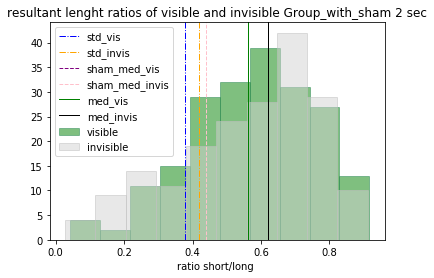

In [45]:
histogram_ratio_with_sham (Day_list, Beacon_list , 2,20 )

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


RanksumsResult(statistic=-0.8681849566581751, pvalue=0.38529308819371855)
1


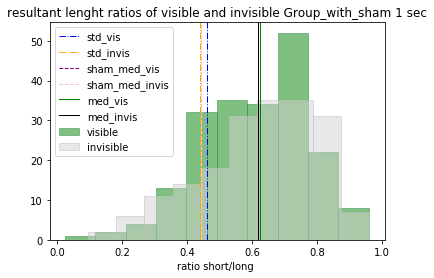

In [46]:
histogram_ratio_with_sham (Day_list, Beacon_list , 1,20 )


RanksumsResult(statistic=-0.27103010417681, pvalue=0.7863678787119113)
4


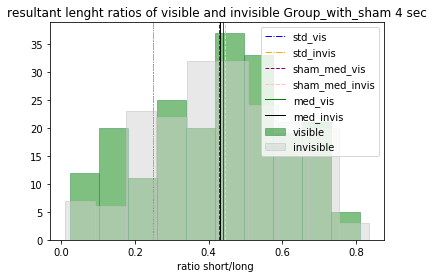

In [47]:
histogram_ratio_with_sham (Day_list, Beacon_list , 4,20 )

## Conclusion: 
    Computign the ratio differences showed no significant differecnes between the lenght ratios of resultant lenght between visible and invisble beacon condition. There was a slight preference at 2 and 3 seconds before the beacon, and when calculatign sham it showed that those ratios are onaverage much smaller than the given ratio from the trials, but not significatonly so.  

####        Note, need to always subtract STD from the mean 
    

## 11. Sliding median window. 
1. calculate median and meand in an array for .1 sec each 
2. calculate simliary for sham condition - 20 repetitions or so 
3. Plot where x axis are the time points and y woudl be medians of ratios - 4 lines vis, and invis for sham and normal 



#### DEBUGGING   - Problems 
1. Trajecotry check - maybe taking 5 seconds instead of 3 as I think due to the pyhton program which has some frame rate at 
50hz not always at 100 
2. for some reason indexign spits out at 2.2 due to the wrong shape (3,221) where it somehow rounds and takes an extra index. - try to fix below, but still does not work  - Kind of fixed manually 
3. Gettign NAN on the bootstrap data - due to division by zero?  - maybe need to normalize time values due to the didison of small numbers where numpy fails 
